**Sliding window and FC to CNN transformation**
This notebooks was created for PRDL and MLLB.

In [ ]:
!pip install keras
import keras

from keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

      
print('Keras version: ',keras.__version__)

In [ ]:
"""
Load and data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)
    
    
# Load data
data = np.load('data_with_labels.npz')

train = data['arr_0']/255.
labels = data['arr_1']

onehot= to_categorical(labels, num_classes=len(np.unique(labels)))

In [ ]:
# Split data into training (90%) and validation (10%)
np.random.seed(100)

indices = np.random.permutation(train.shape[0])

valid_cnt = int(train.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test, train = train[test_idx,:],\
              train[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]


In [ ]:
train=train.reshape([-1,train.shape[1],train.shape[2],1])
test=test.reshape([-1,test.shape[1],test.shape[2],1])

print('Train shape=', train.shape , '\nTest shape=', test.shape)

Train shape= (2511, 36, 36, 1) 
Test shape= (279, 36, 36, 1)


In [ ]:
from keras.models import Sequential

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten

from keras.layers import Convolution2D as Conv2D

from keras.optimizers import SGD

model = Sequential()

# input: 36x36 images with 1 channel -> (36, 36) tensors.
# this applies 4 convolution filters of size 5x5 each.
model.add(Conv2D(4, (5, 5), activation='relu', input_shape=(36, 36,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
# history to analyze training history evolution
print(model.summary())
# validation_data allows to see evaluation on test while training
history1=model.fit(train, onehot_train,
         epochs=100,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)

Some tests for weights shape transformation

In [ ]:
print(np.array(model.layers[3].get_weights()[0]).reshape(16,16,-1).reshape(16,16,4,32).shape)
print(np.array(model.layers[3].get_weights()[1]).shape)

(16, 16, 4, 32)
(32,)


We transform the weights and see if the performance is the same in the new model

In [ ]:
from keras.models import Sequential

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten

from keras.layers import Convolution2D as Conv2D

from keras.optimizers import SGD

model_cnn = Sequential()

# input: 36x36 images with 1 channel -> (36, 36) tensors.
# this applies 4 convolution filters of size 5x5 each.
model_cnn.add(Conv2D(4, (5, 5), activation='relu', input_shape=(36, 36,1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (16, 16), activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Conv2D(5, (1, 1), activation='relu'))
model_cnn.add(Flatten())

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
# history to analyze training history evolution
print(model_cnn.summary())

model_cnn.layers[0].set_weights(model.layers[0].get_weights())
model_cnn.layers[2].set_weights((np.array(model.layers[3].get_weights()[0]).reshape(16,16,-1).reshape(16,16,4,32),model.layers[3].get_weights()[1]))
model_cnn.layers[4].set_weights((np.array(model.layers[5].get_weights()[0]).reshape(1,1,-1).reshape(1,1,32,5),model.layers[5].get_weights()[1]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 4)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          32800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 5)           165       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
Total params: 33,069
Trainable params: 33,069
Non-trainable params: 0
__________________________________________________

Accuracy is the same in both models

In [ ]:
# Check accuracy on test set

loss, accuracy = model.evaluate(test, onehot_test, batch_size=128)
loss1, accuracy1 = model_cnn.evaluate(test, onehot_test, batch_size=128)

print('\nTest FC Accuracy=', accuracy)
print('\nTest CNN Accuracy=', accuracy1)

3/3 [==============================] - 0s 15ms/step - loss: 0.5792 - accuracy: 0.9580

Test FC Accuracy= 0.9569892287254333

Test CNN Accuracy= 0.9569892287254333


In [ ]:
predictions = model_cnn.predict(test)

**Sliding window model**

In [ ]:
from keras.models import Sequential

from keras.layers import MaxPooling2D, Dropout, Dense, Flatten

from keras.layers import Convolution2D as Conv2D

from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(4, (5, 5), activation='relu', input_shape=(72, 72,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (16, 16), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(5, (1, 1), activation='relu'))
for layer1, layer2 in zip(model.layers, model_cnn.layers):
    layer1.set_weights(layer2.get_weights())

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])
# history to analyze training history evolution
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 68, 68, 4)         104       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 19, 32)        32800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 19, 19, 5)         165       
Total params: 33,069
Trainable params: 33,069
Non-trainable params: 0
_________________________________________________________________
None


Zero padding function to increase image size

In [ ]:
from skimage.transform import resize
from skimage.color import gray2rgb

hori=36
vert=36

new_test = np.zeros((test.shape[0],hori,vert,3))
for n,i in enumerate(test):
    new_img = gray2rgb(test[n,:,:,:])
    new_test[n,:,:,:] = np.array(new_img).reshape((hori,vert,3)) #resize(new_img, test.shape[1:], anti_aliasing=True)
    
def zero_padding(X,pad:int):
      X_pad = np.pad(X, ( (pad,pad), (pad,pad), (0,0)), mode='constant', constant_values = (0,0))
      return X_pad

(72, 72, 3)

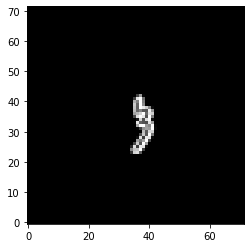

In [ ]:
plt.imshow(zero_padding(new_test[0,:,:,:],18), origin='lower')
zero_padding(new_test[0,:,:,:],18).shape

The sliding model outputs the same as the original model when inputing the same image.

In [ ]:
print("Simple model:",model_cnn.predict(test)[0])
new_test = np.array([zero_padding(test[0,:,:,:],18)])
print("Sliding window:",model.predict(new_test)[0][9][9])

Simple model: [ 0.         6.0740957  0.         4.637305  11.752323 ]
(1, 72, 72, 1)
Sliding window: [ 0.         6.0740957  0.         4.637305  11.752323 ]


We put together 4 images to see if the output is the same when having 4 different classes inside.

In [ ]:
new_images = []
for i in range(int(test.shape[0]/4)):
  new_image = np.c_[test[0+i,:,:,0],test[1+i,:,:,0]]
  _new_image = np.c_[test[2+i,:,:,0],test[3+i,:,:,0]]
  new_image = np.r_[new_image,_new_image]
  new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
  new_images.append(new_image)
new_images = np.array(new_images)
print(new_images.shape)


(69, 72, 72, 1)


Outputs are the same on the corners of the sliding window output


In [ ]:
print("Sliding window:")
new_predictions = model.predict(new_images)
print(new_predictions.shape)
print("First:",new_predictions[0][0][0])
print("Second:",new_predictions[0][0][18])
print("Third:",new_predictions[0][18][0])
print("Forth:",new_predictions[0][18][18])

print(predictions[0:4])

Sliding window:
(69, 19, 19, 5)
First: [ 0.         6.0740957  0.         4.637305  11.752323 ]
Second: [ 8.881792  14.065976   0.         1.3879431  0.       ]
Third: [ 0.       14.101163  0.       13.434556 22.440376]
Forth: [14.962624   0.9552511 15.625244   0.         0.       ]
[[ 0.         6.0740957  0.         4.637305  11.752323 ]
 [ 8.881792  14.065976   0.         1.3879431  0.       ]
 [ 0.        14.101163   0.        13.434556  22.440376 ]
 [14.962624   0.9552511 15.625244   0.         0.       ]]


Prove that the input images where the same for both models.

(72, 72, 3)


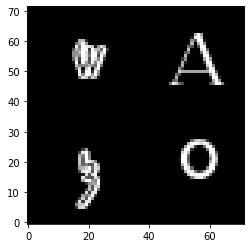

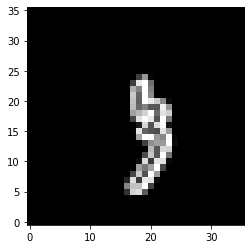

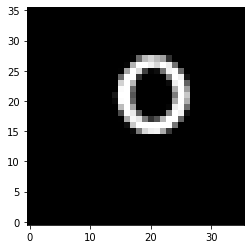

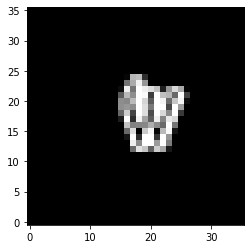

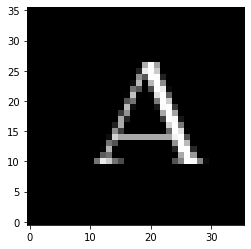

In [ ]:
new_new_images = np.zeros((new_images.shape[0],new_images.shape[1],new_images.shape[2],3))
for n,i in enumerate(new_images):
    new_img = gray2rgb(new_images[n,:,:,:])
    new_new_images[n,:,:,:] = np.array(new_img).reshape((new_images.shape[1],new_images.shape[2],3))
print(new_new_images[0].shape)
#for i in range(len(new_new_images))
plt.imshow(new_new_images[0,:,:,:], origin='lower')
plt.show()
plt.imshow(new_test[0,:,:,:], origin='lower')
plt.show()
plt.imshow(new_test[1,:,:,:], origin='lower')
plt.show()
plt.imshow(new_test[2,:,:,:], origin='lower')
plt.show()
plt.imshow(new_test[3,:,:,:], origin='lower')
plt.show()